<a href="https://colab.research.google.com/github/ahmabboud/Spinal-Implants-Classification/blob/main/Implant_Xray_Unet_FastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from matplotlib import pyplot as plt
from fastai.vision import *
from fastai.callbacks.hooks import *
#from PIL import Image

## Data Preparation

In [ ]:
# ref: https://forums.fast.ai/t/image-segmentation-on-coco-dataset-summary-questions-and-suggestions/36816/3
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils 

In [ ]:
path = Path('drive/MyDrive/Client_DS1/')
#cocoTrain = dset.CocoDetection(root=path/'datasets/implant_Train', annFile=path/'implant_Train-2.json')
#cocoValid = dset.CocoDetection(root=path/'datasets/implant_Test', annFile=path/'implant_Test-1.json')

ANNOTATION_FILE_Test=path/'implant_Test-1.json'
ANNOTATION_FILE_Train=path/'implant_Train-2.json'

#read COCO annatation file (JSON) and save the images for your category into a dictionary:
coco_Test = coco.COCO(ANNOTATION_FILE_Test)
coco_Train = coco.COCO(ANNOTATION_FILE_Train)

#set the category (read COCO metadata if you don’t know them) 
#you are interested in (remember, bynary segmentation -> choose only one):
CATEGORY_NAMES=[coco_Test.cats[i]['name'] for i in coco_Test.cats.keys()]

TARGET_CLASSES=CATEGORY_NAMES.copy()
classes = array(TARGET_CLASSES, dtype='<U17')
catIds = coco_Test.getCatIds(catNms=CATEGORY_NAMES)

imgIds_Test = list(set([i['image_id'] for i in coco_Test.dataset['annotations']])) # by AHB #coco.dataset['annotations'].getImgIds(catIds=catIds)
imgIds_Train = list(set([i['image_id'] for i in coco_Train.dataset['annotations']]))

imgDict_Test = coco_Test.loadImgs(imgIds_Test)
imgDict_Train = coco_Train.loadImgs(imgIds_Train)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
coco_Test.dataset.keys(), coco_Train.dataset.keys()

(dict_keys(['images', 'categories', 'annotations']),
 dict_keys(['images', 'categories', 'annotations']))

In [ ]:
len(imgIds_Test) , len(imgIds_Train)

(61, 142)

In [ ]:
#I also created a DataFrame to easily access some metadata (there may be an easier way):
imgDF_Test = pd.DataFrame.from_dict(imgDict_Test)
imgDF_Train = pd.DataFrame.from_dict(imgDict_Train)
imgDF_Test.head(5)

,id,dataset_id,category_ids,path,width,height,file_name,annotated,annotating,num_annotations,metadata,deleted,milliseconds,events,regenerate_thumbnail
0,1281,2,[],/datasets/implant_Test/S_283_2.jpg,454,246,S_283_2.jpg,False,[],0,{},False,0,[],False
1,1538,2,[],/datasets/implant_Test/S_233_3.jpg,366,258,S_233_3.jpg,False,[],0,{},False,0,[],False
2,1539,2,[],/datasets/implant_Test/S_315_5.jpg,344,256,S_315_5.jpg,False,[],0,{},False,0,[],False
3,1284,2,[],/datasets/implant_Test/S_180_2.jpg,448,256,S_180_2.jpg,False,[],0,{},False,0,[],False
4,1540,2,[],/datasets/implant_Test/S_37_2.jpg,267,256,S_37_2.jpg,False,[],0,{},False,0,[],False


In [ ]:
#file_path='drive/MyDrive/Client_DS1/datasets/implant_Test/S_283_2.jpg'
#cocoF=coco_Test
#imgDF=imgDF_Test
def createImageForMask(file_path,cocoF,imgDF):
  file_name = str(file_path).split("/")[-1]
  out_data= imgDF[imgDF['file_name']==file_name]
  #print(out_data['id'])
  index= int(out_data['id'])    #edited by AHB to take one image out of many
  
  #sampleImgIds = coco_Test.getImgIds(imgIds = [index])
  sampleImgDict = cocoF.loadImgs(index)[0] # 0 to gett inner list
  annIds = cocoF.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds, iscrowd=None)
  anns = cocoF.loadAnns(annIds)
  mask = cocoF.annToMask(anns[0]) 
  
  for i in range(len(anns)):
      mask = mask | cocoF.annToMask(anns[i])
      #catid= 1 if anns[i]['category_id']==6 else 2 # this to make sure that clasees str 0 
      #segment=catid & cocoF.annToMask(anns[i])    # Crosslink id 1 and Hook 2  
      #mask = mask | segment
  img=Image(pil2tensor(mask, dtype=np.int32))
  
  #img=Image.fromarray(mask)
  #img.show()
  img.save(MASK_PATH/file_name)
  return MASK_PATH/file_name

In [ ]:
mask=open_mask('drive/MyDrive/Client_DS1/datasets/Mask_Test/S_283_2.jpg')
#img.show()
torch.unique(mask.data)

tensor([0, 1, 2])

In [ ]:
print(mask.shape) 
print(mask.data) 
torch.unique(mask.data)

torch.Size([1, 246, 454])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


tensor([0, 1, 2])

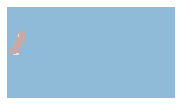

In [ ]:
s=open_image('drive/MyDrive/Client_DS1/datasets/Mask_Test/S_283_2.jpg').data.shape
img=open_mask('drive/MyDrive/Client_DS1/datasets/Mask_Test/S_283_2.jpg')
#img.show()
img.show()

In [ ]:
an_image = PIL.Image.open('drive/MyDrive/Client_DS1/datasets/Mask_Test/S_283_2.jpg')
image_sequence = an_image.getdata()
image_array = np.array(image_sequence)
print(np.unique(image_array))

[0 1 2]


In [ ]:
print(torch.unique(img.data))

tensor([0, 1, 2])


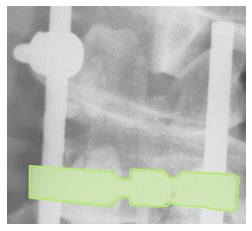

In [ ]:
ID=1219
sampleImgIds = coco_Test.getImgIds(imgIds = [ID])
sampleImgDict = coco_Test.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]
I = plt.imread(path/sampleImgDict['path'][1:])
plt.imshow(I); plt.axis('off')
annIds = coco_Test.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds, iscrowd=0)
anns = coco_Test.loadAnns(annIds)
coco_Test.showAnns(anns)

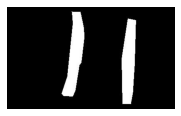

In [ ]:
#id 1273 two crosslinks
#Using function createImageForMask
MASK_PATH=path/"datasets/Mask_Test"
sampleImgDict = coco_Test.loadImgs(1273)[0]
img2=open_image(createImageForMask(path/sampleImgDict['path'][1:],coco_Test,imgDF_Test))
img2.show()
#torch.unique(img2.data)

{0, 1}


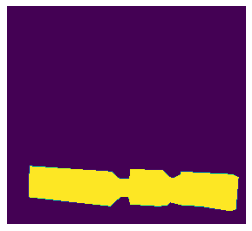

In [ ]:
mask = coco_Test.annToMask(anns[0])
for i in range(len(anns)):
    mask = mask | coco_Test.annToMask(anns[i])
plt.imshow(mask) ; plt.axis('off')

pixVals = set()
for pixRow in mask:
  for pix in pixRow:
    pixVals.add(pix)
print(pixVals)

In [ ]:
print(np.unique(mask))

[0 1]


In [ ]:
#function that can remove from IMG_PATH all files which are not listed in annotation file (to avoid error in databunch) for existing annotations it creates the imageMask:
def dataPreparation(cocoF,imgDF):
  deleted = 0
  processed = 0
  imgCounter = 0
  for f in os.listdir(IMG_PATH):
    imgCounter = imgCounter + 1
    if(imgCounter == 1000000):
      break
    df = imgDF[imgDF['file_name']==f]
    if(df.empty):
      print("delete file: "+f)
      os.remove(IMG_PATH/f) 
      deleted = deleted + 1
    else:
      createImageForMask(f,cocoF,imgDF)
      processed = processed + 1
  print('deleted '+str(deleted)+' files')
  print('processed '+str(processed)+' files')

In [ ]:
# Create image mask for Test imgs
IMG_PATH=path/"datasets/implant_Test"
MASK_PATH=path/"datasets/Mask_Test"
dataPreparation(coco_Test,imgDF_Test)

deleted 0 files
processed 61 files


In [ ]:
# Create image mask for Train imgs
IMG_PATH=path/"datasets/implant_Train"
MASK_PATH=path/"datasets/Mask_Train"

dataPreparation(coco_Train,imgDF_Train)

deleted 0 files
processed 142 files


In [ ]:
class MySegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)

class MySegmentationItemList(ImageList):
    #"`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = MySegmentationLabelList,False

In [ ]:
def get_y_fn(file_path):
  file_name=str(file_path).split("/")[-1]
  return MASK_PATH/file_name


In [ ]:
imgDF_Train['valid']=False
imgDF_Train['mask']=imgDF_Train['path'].apply(lambda x: x.replace("implant_Train",'Mask_Train'))
imgDF_Test['valid']=True

imgDF_Test['mask']=imgDF_Test['path'].apply(lambda x: x.replace("implant_Test",'Mask_Test'))
imgDF_Complete=pd.concat([imgDF_Train,imgDF_Test],ignore_index=True)
imgDF_Complete['path']=imgDF_Complete['path'].apply(lambda x: x.replace("/datasets","drive/MyDrive/Client_DS1/datasets"))
imgDF_Complete['mask']=imgDF_Complete['mask'].apply(lambda x: x.replace("/datasets","drive/MyDrive/Client_DS1/datasets"))
imgDF_Complete.sample(2)

,id,dataset_id,category_ids,path,width,height,file_name,annotated,annotating,num_annotations,metadata,deleted,milliseconds,events,regenerate_thumbnail,valid,mask
60,2252,3,[],drive/MyDrive/Client_DS1/datasets/implant_Trai...,368,250,S_211_3.jpg,False,[],0,{},False,0,[],False,False,drive/MyDrive/Client_DS1/datasets/Mask_Train/S...
117,1920,3,[],drive/MyDrive/Client_DS1/datasets/implant_Trai...,416,242,S_124_1.jpg,False,[],0,{},False,0,[],False,False,drive/MyDrive/Client_DS1/datasets/Mask_Train/S...


In [ ]:
# save to csv 
Complete_df_file = os.path.join(path,'Complete.csv')
imgDF_Complete.to_csv(Complete_df_file, index=False)

In [ ]:
src = MySegmentationItemList.from_df(cols='path',df=imgDF_Complete,path="").split_from_df(col='valid').label_from_df('mask', classes=TARGET_CLASSES)

In [ ]:
tfms = get_transforms()
np.random.seed(24)
data = (src.transform(tfms, size=256, tfm_y=True)
        .databunch(bs=16, num_workers=4)
        .normalize(imagenet_stats))

In [ ]:
data.c

2

In [ ]:
path = Path('drive/MyDrive/Client_DS1/')
MASK_PATH=path/"datasets/Mask_Test"
IMG_PATH=path/'datasets/implant_Test'
test_data=ImageList.from_folder(IMG_PATH)

In [ ]:
data.add_test(test_data ,tfms=None, tfm_y=False)

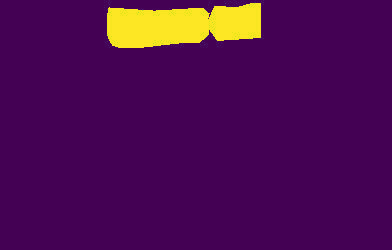

In [ ]:
data.train_ds.y[7]

## Modeling


In [ ]:
acc_05 = partial(accuracy_thresh, thresh=0.5)
wd=1e-2
learn = unet_learner(data, models.resnet34, wd=wd)
learn.opt_fn=optim.Adam
learn.metrics=[acc_05]
path=Path('drive/MyDrive/Client_DS1/Models')
learn.path=path

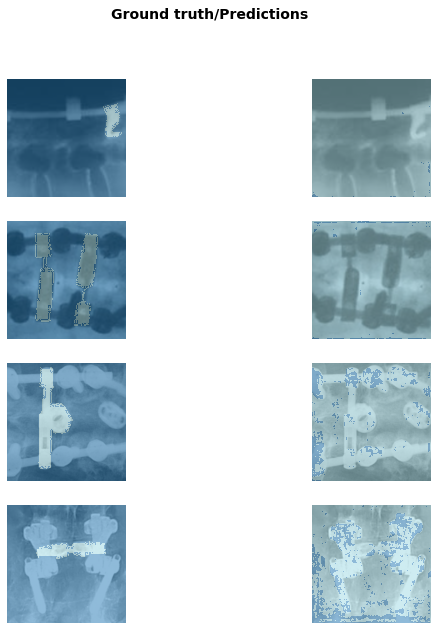

In [ ]:
learn.show_results(rows=4, figsize=(10, 10))

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


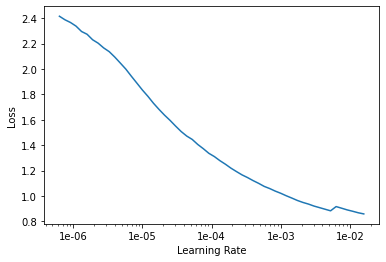

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
# lr = slice(1e-06,1e-04)
learn.fit_one_cycle(3, slice(1e-06,1e-04), pct_start=0.9) 

epoch,train_loss,valid_loss,accuracy_thresh,time
0,1.443108,0.481622,0.480974,00:19
1,0.938438,0.462269,0.495087,00:15
2,0.756048,0.355920,0.498454,00:15


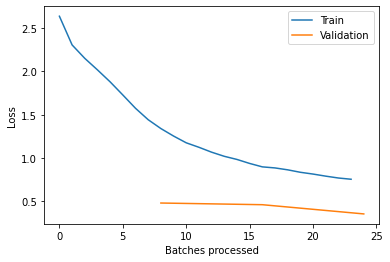

In [ ]:
learn.recorder.plot_losses()

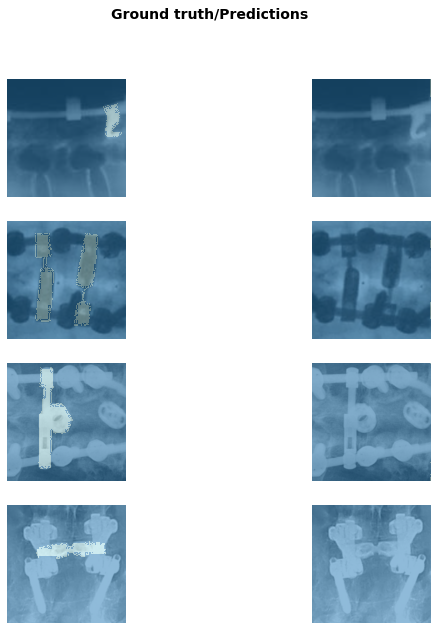

In [ ]:
learn.show_results(rows=4, figsize=(10, 10))

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.74E-04


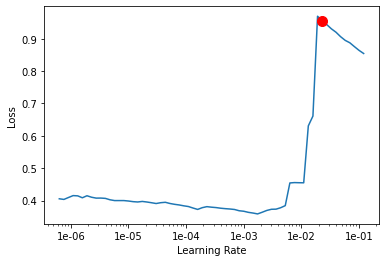

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, slice(2e-6,3e-5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.412963,0.372086,0.437423,00:16
1,0.389837,0.327986,0.466054,00:16
2,0.371931,0.337360,0.496693,00:16
3,0.361720,0.305328,0.470022,00:16
4,0.346752,0.305979,0.475428,00:16


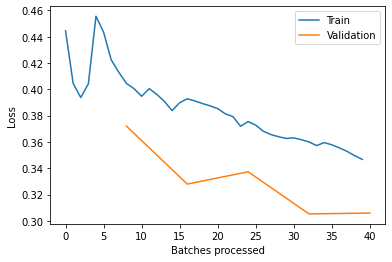

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2_15ep')

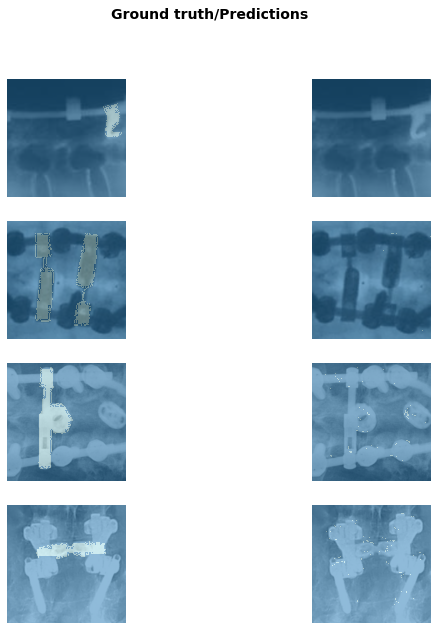

In [ ]:
learn.show_results(rows=4, figsize=(10, 10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 4.79E-05


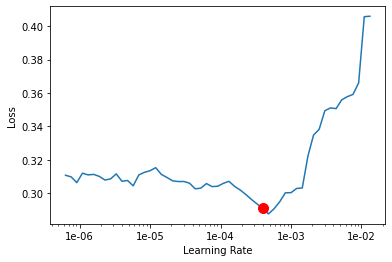

In [ ]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, slice(1e-5,1e-4) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.334936,0.307445,0.478837,00:16
1,0.329145,0.293692,0.489845,00:16
2,0.305412,0.373082,0.496565,00:16
3,0.282799,0.335573,0.496182,00:16
4,0.264554,0.370810,0.497842,00:16


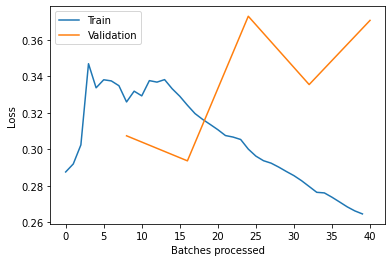

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('Stage_3_10ep')

In [ ]:
learn.fit_one_cycle(5, slice(1e-6,1e-5) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.217744,0.343189,0.496783,00:16
1,0.226548,0.324828,0.495910,00:16
2,0.220722,0.358249,0.497543,00:16
3,0.216985,0.320238,0.495803,00:16
4,0.214413,0.319546,0.495504,00:16


In [ ]:
learn.fit_one_cycle(10,slice(1e-7,1e-5) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.199460,0.325541,0.495829,00:16
1,0.200281,0.356944,0.497149,00:16
2,0.203187,0.335011,0.496316,00:16
3,0.206033,0.345254,0.496914,00:16
4,0.203927,0.331135,0.496717,00:16
5,0.202075,0.350381,0.497202,00:16
6,0.199696,0.315513,0.496181,00:16
7,0.197399,0.339743,0.497008,00:16
8,0.195506,0.351050,0.497280,00:16
9,0.194350,0.348202,0.497213,00:16


In [ ]:
learn.fit_one_cycle(10,slice(1e-5,1e-4) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.179902,0.338900,0.496715,00:16
1,0.185788,0.302932,0.495837,00:16
2,0.193417,0.351560,0.500225,00:16
3,0.204987,0.293879,0.502820,00:16
4,0.201033,0.331639,0.504176,00:16
5,0.195605,0.355976,0.503251,00:16
6,0.188439,0.286157,0.505923,00:16
7,0.181030,0.351824,0.500827,00:16
8,0.172894,0.368158,0.500815,00:16
9,0.167442,0.362860,0.500750,00:16


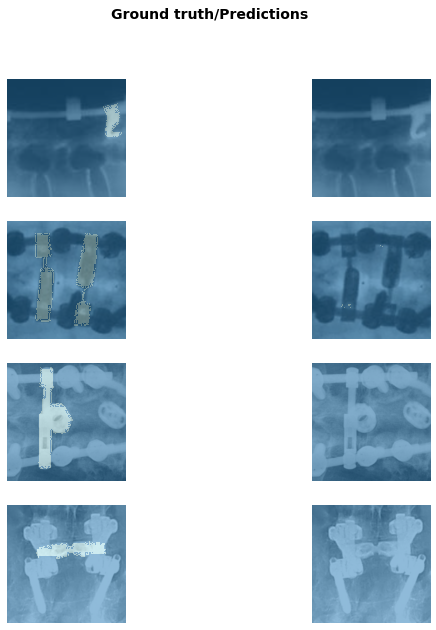

In [ ]:
learn.show_results(rows=4, figsize=(10, 10))

In [ ]:
learn.fit_one_cycle(10,slice(1e-4,5e-4) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.146034,0.342242,0.501534,00:16
1,0.185350,0.271581,0.507231,00:16
2,0.227705,0.340773,0.617344,00:16
3,0.338729,0.384412,0.555923,00:16
4,0.360633,0.331723,0.517677,00:16
5,0.366693,0.321853,0.517597,00:15
6,0.367467,0.303204,0.522818,00:16
7,0.358109,0.309590,0.510616,00:16
8,0.349957,0.298833,0.518603,00:16
9,0.342254,0.303250,0.514073,00:15


In [ ]:
learn.save('stage_4')

In [ ]:
learn.fit_one_cycle(3,slice(1e-4,5e-3) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.518338,0.423019,0.499999,00:16
1,1.416886,0.381756,0.499807,00:16
2,1.051097,0.413582,0.424858,00:15


In [ ]:
learn.fit_one_cycle(3,slice(1e-4,5e-4) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.408021,0.391595,0.498012,00:16
1,0.393292,0.337657,0.499745,00:15
2,0.383520,0.346111,0.499783,00:16


In [ ]:
learn.fit_one_cycle(3,slice(1e-3,5e-3) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.385407,0.350459,0.499933,00:19
1,0.457734,0.384061,0.461127,00:17
2,0.430496,0.370010,0.499212,00:17


In [ ]:
learn.fit_one_cycle(3,slice(1e-3,1e-2) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.358075,0.379631,0.499769,00:17
1,0.383486,0.398440,0.503023,00:17
2,0.388561,0.334195,0.499652,00:17


In [ ]:
learn.fit_one_cycle(3,slice(1e-2,5e-2) )

epoch,train_loss,valid_loss,accuracy_thresh,time
0,35133.816406,inf,0.500000,00:17
1,935712580960256.000000,1591709305971781501190144.000000,0.881068,00:17
2,2805329024778240.000000,25408388720492544.000000,0.500000,00:16


## Evaluation

In [ ]:
path=Path('drive/MyDrive/Client_DS1/Models')
learn.path=path

In [ ]:
learn.load('stage-2_13ep')